# Importing the Necessary Libraries

In [1]:
import scipy.io
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

import tensorflow as tf

import keras
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Activation
from keras.layers import Conv2D, AveragePooling2D
from keras.models import Model, Sequential

from sklearn.model_selection import train_test_split

from keras import metrics

from keras.models import model_from_json
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Data Source - wiki data source
# https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/
# Extracting wiki_crop.tar creates 100 folders and an index file (wiki.mat). The index file is saved as Matlab format. We can read Matlab files in python with SciPy

In [3]:

mat = scipy.io.loadmat('wiki_crop/wiki.mat')

# Converting it to Pandas Dataframe as it makes the transformation easy in my case

In [4]:
columns = ["dob", "photo_taken", "full_path", "gender", "name", "face_location", "face_score", "second_face_score"]

In [5]:
instances = mat['wiki'][0][0][0].shape[1]

df = pd.DataFrame(index = range(0,instances), columns = columns)

In [6]:
for i in mat:
    if i == "wiki":
        current_array = mat[i][0][0]
        for j in range(len(current_array)):
            #print(columns[j],": ",current_array[j])
            df[columns[j]] = pd.DataFrame(current_array[j][0])

In [7]:
df.head()

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score
0,723671,2009,[17/10000217_1981-05-05_2009.jpg],1.0,[Sami Jauhojärvi],"[[111.29109473290997, 111.29109473290997, 252....",4.300962,NaN
1,703186,1964,[48/10000548_1925-04-04_1964.jpg],1.0,[Dettmar Cramer],"[[252.48330229530742, 126.68165114765371, 354....",2.645639,1.949248
2,711677,2008,[12/100012_1948-07-03_2008.jpg],1.0,[Marc Okrand],"[[113.52, 169.83999999999997, 366.08, 422.4]]",4.329329,NaN
3,705061,1961,[65/10001965_1930-05-23_1961.jpg],1.0,[Aleksandar Matanović],"[[1, 1, 634, 440]]",-inf,NaN
4,720044,2012,[16/10002116_1971-05-31_2012.jpg],0.0,[Diana Damrau],"[[171.61031405173117, 75.57451239763239, 266.7...",3.408442,NaN


# Data Cleaning

In [8]:
#remove pictures does not include face
df = df[df['face_score'] != -np.inf]

#some pictures include more than one face, remove them
df = df[df['second_face_score'].isna()]

#check threshold
df = df[df['face_score'] >= 3]

#some records do not have a gender information
df = df[~df['gender'].isna()]

In [9]:
df = df.drop(columns = ['dob','photo_taken','name','face_score','second_face_score','face_location'])

In [10]:
df.head()

,full_path,gender
0,[17/10000217_1981-05-05_2009.jpg],1.0
2,[12/100012_1948-07-03_2008.jpg],1.0
4,[16/10002116_1971-05-31_2012.jpg],0.0
5,[02/10002702_1960-11-09_2012.jpg],0.0
6,[41/10003541_1937-09-27_1971.jpg],1.0


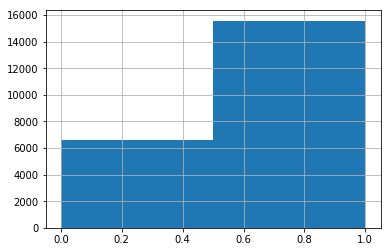

In [11]:
histogram = df['gender'].hist(bins=df['gender'].nunique())

In [12]:
df['gender'].value_counts().sort_index()
#0: woman, 1: man

0.0     6580
1.0    15575
Name: gender, dtype: int64

# We just need 2 classes 

In [13]:
classes = 2 #man woman
print("number of output classes: ",classes)

number of output classes:  2


# Getting Pixels of images

In [14]:
target_size = (224, 224)

def getImagePixels(directory):
    features = dict()
    for name in listdir(directory):
        img = image.load_img(directory + "/%s" % image_path[0], grayscale=False, target_size=target_size)
        x = image.img_to_array(img).reshape(1, -1)[0]
        image_id = name.split('.')[0]
        features[image_id] = x
    return features

# Getting features and target for our model

In [17]:
target = df['gender'].values
target_classes = keras.utils.to_categorical(target, classes)

In [18]:
directory = 'wiki_crop'
features = getImagePixels(directory)

features = np.array(features)
features = features.reshape(features.shape[0], 224, 224, 3)

In [19]:
features.shape

(22155, 224, 224, 3)

In [20]:
features /= 255 #normalize in [0, 1]

# Splitting the Data

In [21]:
train_x, test_x, train_y, test_y = train_test_split(features, target_classes, test_size=0.30)

# Building a model for age prediction (inspiration taken from VGG-Face Model)

In [22]:
#VGG-Face model
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

In [24]:
#freeze all layers of VGG-Face except last 7 one
for layer in model.layers[:-7]:
    layer.trainable = False

base_model_output = Sequential()
base_model_output = Convolution2D(classes, (1, 1), name='predictions')(model.layers[-4].output)
base_model_output = Flatten()(base_model_output)
base_model_output = Activation('softmax')(base_model_output)

gender_model = Model(inputs=model.input, outputs=base_model_output)

In [26]:
sgd = keras.optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)

gender_model.compile(loss='categorical_crossentropy'
                  , optimizer=keras.optimizers.Adam()
                  #, optimizer = sgd
                  , metrics=['accuracy']
                 )

In [27]:
checkpointer = ModelCheckpoint(
    filepath='classification_gender_model.hdf5'
    , monitor = "val_loss"
    , verbose=1
    , save_best_only=True
    , mode = 'auto'
)

In [ ]:
scores = []

In [43]:
epochs = 250
batch_size = 256

for i in range(epochs):
    print("epoch ",i)
        
    ix_train = np.random.choice(train_x.shape[0], size=batch_size)
        
    score = gender_model.fit(
        train_x[ix_train], train_y[ix_train]
        , epochs=1
        , validation_data=(test_x, test_y)
        , callbacks=[checkpointer]
    )
        
    scores.append(score)
        
    from keras.models import load_model
    gender_model = load_model("classification_gender_model.hdf5")
        
    gender_model.save_weights('gender_model_weights.h5')
        

# the model gets saturated 

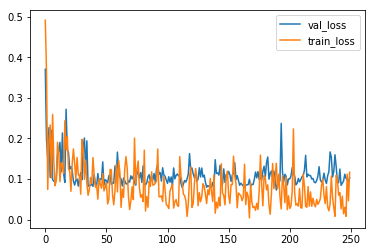

In [30]:
val_loss_change = []; loss_change = []
for i in range(0, len(scores)):
    val_loss_change.append(scores[i].history['val_loss'])
    loss_change.append(scores[i].history['loss'])

plt.plot(val_loss_change, label='val_loss')
plt.plot(loss_change, label='train_loss')
plt.legend(loc='upper right')
plt.show()

# Testing model on the testing set

In [35]:
#loss and accuracy on validation set
gender_model.evaluate(test_x, test_y, verbose=1)

6647/6647 [==============================] - 17s 2ms/step


[0.07324957040103375, 0.9744245524655362]

In [37]:
predictions = gender_model.predict(test_x)

In [38]:
from sklearn.metrics import classification_report, confusion_matrix

pred_list = []; actual_list = []

for i in predictions:
    pred_list.append(np.argmax(i))

for i in test_y: 
    actual_list.append(np.argmax(i))

confusion_matrix(actual_list, pred_list)

array([[1873,   98],
       [  72, 4604]])